# Linear regression via backpropagation

In linear regression we seek to figure out the correct coefficients $w$ to predict $y$ from the known values of $x$. Because it's a linear equation, this means solving 
$$ y = w x + b $$
for the values of $w$ and $b$. Of course it's possible that multiple inputs are required to predict $y$, so instead of predicting it with a single value of $x$, we instead call it a vector, $\vec{x}$, where the $j$th element is $x_j$ and the coefficient for that value is $w_j$. We can therefore update the equation to be 
$$y = \sum_j w_j x_j + b = \vec{w} \cdot \vec{x} + b. $$

## Traditional solution

Normally this equation is solved in one step. We take all of the $y$ values we know and all of the $\vec{x}$ values we know and treat them as a matrix, $\mathbf{X}$. In a perfect, no-noise world we can then invert $\mathbf{X}$ (once a column of $1$ values has been added to account for the intercept term, $b$).

$$ \vec{y} = \mathbf{X} \vec{w} $$

This is a traditional linear equation, and we can find $\vec{w}$ by inverting $\mathbf{X}$.

$$\vec{w} = \mathbf{X}^{-1} \vec{y}$$

This solution depends on the assumptions:
- we have exactly as many equations as we have unknowns and
- the inputs are linearly independent.

Let's ignore the second assumption for now, and focus only on the first. In the real world, the presence of noise in the inputs ($\mathbf{X}$) and output ($\vec{y}$ means this equation isn't perfect. We can compensate for this by collecting a lot of values for $\vec{x}$ and assuming that the noise is centered on the true values of $\vec{x}$. This means we can use the *pseudoinverse* of $\mathbf{X}$.

$$ \vec{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \vec{y} $$

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
X = np.random.random((30, 3))
# Our true values of w are (2, 0.5, and 1)
y = X[:,0] * 2 + X[:,1] * 0.5 + X[:, 2] * 1 + np.random.randn(30) * 0.05

In [3]:
w = la.inv(X.T @ X) @ X.T @ y

In [4]:
yp = X @ w

Text(0, 0.5, 'Predicted value')

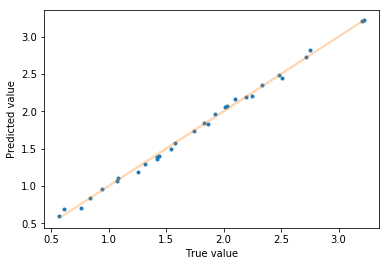

In [5]:
plt.plot(y, yp, '.')
plt.plot(y, y, alpha=0.3)
plt.xlabel('True value')
plt.ylabel('Predicted value')

In [6]:
w

array([2.02300702, 0.47979013, 1.02702003])

There is a little more math to show that this is, in fact, the solution that minimizes the **mean squared error**, (MSE), but for now, just trust me. Of course we are going to be interested in that value later, so knowing an equation for it later is going to be important.

$$ E = \frac{1}{2} (\vec{y} - \mathbf{X} \vec{w})^T (\vec{y} - \mathbf{X} \vec{w}) $$

## Gradient descent

Instead of collecting all the data and looking at it all at once (which requires inverting what could be a really large matrix), we could also try something different. Now that we have an equation for error as a function of $\vec{w}$ we can imagine looking at a graph of Error vs. $\vec{w}$. 

In [7]:
import matplotlib.pyplot as plt

In [8]:
def sse(y, yp):
    e = y - yp
    return 0.5 * np.sum(e ** 2)

This is going to get a little squirrely in more than one dimension, so let's dial back to that for now. I promise we will add more later.

In [9]:
X = np.random.random((30, 1))
noise = np.random.randn(30)
y = 2.5 * X[:,0] + np.random.randn(30) * 0.05

In [10]:
w = np.linspace(0, 5).reshape((-1, 1))

In [11]:
yp = w @ X.T

In [12]:
yp.shape

(50, 30)

In [13]:
e = np.array([sse(y, ypp) for ypp in yp])

Let's say we made an initial guess at $w=1$.

Text(1.0, 12.052199132080174, '')

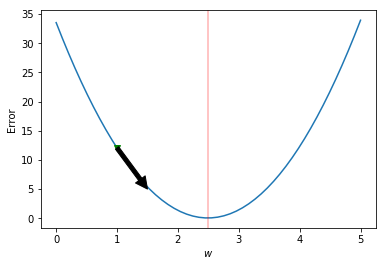

In [14]:
plt.plot(w, e)
plt.axvline(x=2.5, color='r', alpha=0.3)
plt.ylabel("Error")
plt.xlabel(r"$w$")
plt.plot(1.0, sse(y, X.ravel()), "gv")
plt.annotate('', xy=(1.5, 5), xycoords='data',
             textcoords='data', arrowprops=dict(facecolor='black'),
             xytext=(1.0, sse(y, X.ravel())))

From the slope of the error function we can see that if we just bump $w$ up a little, the error will go down. Of course, if we just move it a little bit we won't get to the perfect minimum. If we move it too far, though, we'll skip past the minimum. The distance we move in the direction of that arrow is called the learning rate ($\eta$) and is the subject of a lot of literature. For now, we'll just pick a number and make sure it's not too big. So every time we train we will figure out the error to see where we are on the curve. Then we calculate the slope of the error where we are and move a little bit down the slope.

## Backpropagation

But wait! All we know is the error at a single point. How can we calculate the slope (derivative) of the error with respect to $w$?

$$ E = \frac{1}{2} (\vec{y} - \mathbf{X} \vec{w})^T (\vec{y} - \mathbf{X} \vec{w}) $$

Since we're just dealing with one point here we'll simplify this.

$$ E = \frac{1}{2} (y - y^\prime)^2 = \frac{1}{2} (y - \sum_i w_i x_i - b)^2$$

Now take the derivative of $E$ with respect to $w$

$$ \frac{dE}{dw_i} = -x_i (y - \sum_i w_i x_i - b) $$

and the derivative with respect to the bias is

$$ \frac{dE}{db} = -(y - \sum_i w_i x_i - b) $$

Okay, cool! We know all of these things! If this value is positive, it means that increasing $w$ will also increase our error. If it's negative, it means that increasing $w$ will lower our error.

## Training

So here is our training process:
1. Make an initial guess for the weights, 
2. calculate an error for that guess, 
3. add $\eta (y - wx) x$ to each weight, and
4. repeat 2-3 until convergence.

In [15]:
class Neuron():
    def __init__(self, ninputs):
        self._weights = np.random.randn(ninputs) * 0.01
        self._bias = np.random.randn() * 0.01
    
    def predict(self, X):
        x = np.atleast_2d(X)
        return x @ self._weights + self._bias
    
    def error(self, X, y):
        yp = self.predict(X)
        e = 0.5 * (y - yp) ** 2
        return e
    
    def delta(self, X, y, w):
        yp = self.predict(X)
        return (y - yp)
    
    def fit(self, X, y, lr=0.01):
        yp = self.predict(X)
        e = y - yp
        self._weights += lr * X * e
        self._bias += lr * e

In [16]:
n = Neuron(3)

In [17]:
X = np.random.random((300, 3))
y = X[:,0] * 2 + X[:,1] * 0.5 + X[:, 2] * 1 + 4.0 + np.random.randn(300) * 0.05

The correct weights are $2.0$, $0.5$, and $1.0$. The correct bias is $4.0$.

In [18]:
n._weights

array([-0.00967352, -0.00035365,  0.0013613 ])

In [19]:
n._bias

0.01030182807534045

In [20]:
np.mean(n.error(X, y))

17.090901513156783

In [21]:
n_epochs = 100
epochs = range(n_epochs)
errors = []
biases = [n._bias]
w0 = [n._weights[0]]
w1 = [n._weights[1]]
w2 = [n._weights[2]]

for epoch in epochs:
    for Xi, yi in zip(X, y):
        n.fit(Xi, yi)

    errors.append(np.mean(n.error(X, y)))
    biases.append(n._bias)
    w0.append(n._weights[0])
    w1.append(n._weights[1])
    w2.append(n._weights[2])

In [22]:
n._weights

array([1.99343735, 0.50134331, 1.00737719])

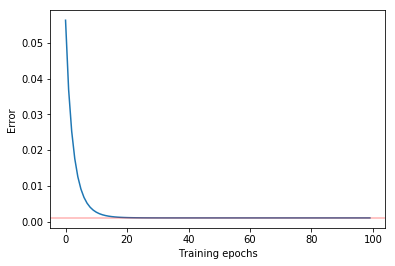

In [23]:
plt.plot(epochs, errors)
plt.xlabel('Training epochs')
plt.ylabel('Error')
plt.axhline(y=errors[-1], color='r', alpha=0.3)

In [24]:
n._weights

array([1.99343735, 0.50134331, 1.00737719])

In [25]:
n._bias

array([4.00085343])

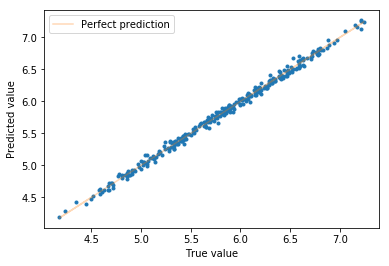

In [26]:
plt.plot(y, n.predict(X), '.')
plt.plot(y, y, label='Perfect prediction', alpha=0.3)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.legend(loc='best')

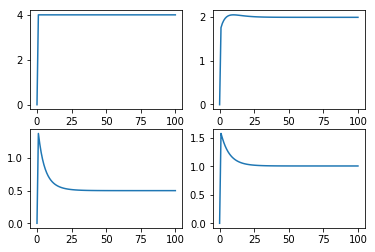

In [27]:
f = plt.figure()

plt.subplot(221)
plt.plot(biases)

plt.subplot(222)
plt.plot(w0)

plt.subplot(223)
plt.plot(w1)

plt.subplot(224)
plt.plot(w2)

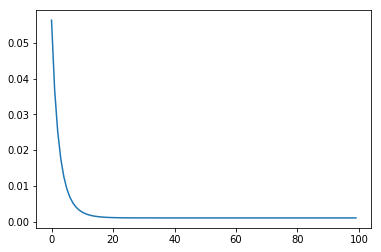

In [28]:
plt.plot(errors)

In [29]:
n._weights

array([1.99343735, 0.50134331, 1.00737719])

In [30]:
n._bias

array([4.00085343])

Pretty close! Now let's look at what happens with a lower learning rate

In [31]:
n2 = Neuron(3)

In [32]:
n_epochs = 5000
epochs = range(n_epochs)
errors = []
biases = [n2._bias]
w0 = [n2._weights[0]]
w1 = [n2._weights[1]]
w2 = [n2._weights[2]]

for epoch in epochs:
    for Xi, yi in zip(X, y):
        n2.fit(Xi, yi, lr=0.0001)

    errors.append(np.mean(n2.error(X, y)))
    biases.append(n2._bias)
    w0.append(n2._weights[0])
    w1.append(n2._weights[1])
    w2.append(n2._weights[2])

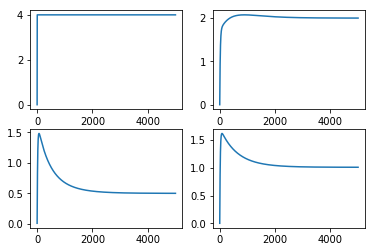

In [33]:
f = plt.figure()

plt.subplot(221)
plt.plot(biases)

plt.subplot(222)
plt.plot(w0)

plt.subplot(223)
plt.plot(w1)

plt.subplot(224)
plt.plot(w2)

In [34]:
n2._weights

array([1.99331039, 0.50071975, 1.00729297])

In [35]:
n2._bias

array([3.99920922])

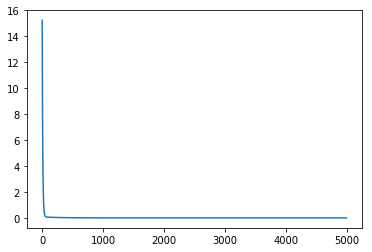

In [36]:
plt.plot(errors)

So with a very low learning rate, the values did not coverge completely even after 1000 loops through the training data. 5000 did the trick though! Now let's look at what happens when the learning rate is very high

In [37]:
n3 = Neuron(3)

n_epochs = 10
epochs = range(n_epochs)
errors = []
biases = [n3._bias]
w0 = [n3._weights[0]]
w1 = [n3._weights[1]]
w2 = [n3._weights[2]]

for epoch in epochs:
    for Xi, yi in zip(X, y):
        n3.fit(Xi, yi, lr=1.0)

    errors.append(np.mean(n3.error(X, y)))
    biases.append(n3._bias)
    w0.append(n3._weights[0])
    w1.append(n3._weights[1])
    w2.append(n3._weights[2])

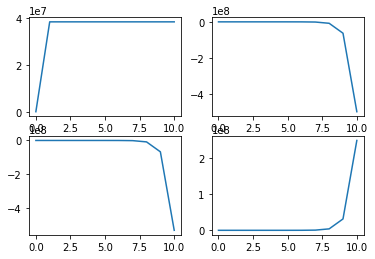

In [38]:
f = plt.figure()

plt.subplot(221)
plt.plot(biases)

plt.subplot(222)
plt.plot(w0)

plt.subplot(223)
plt.plot(w1)

plt.subplot(224)
plt.plot(w2)

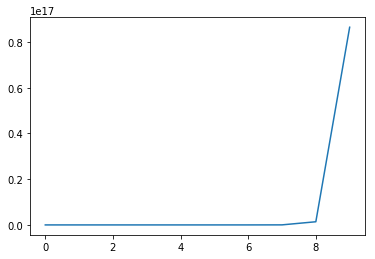

In [39]:
plt.plot(errors)

In [40]:
n3._weights

array([-4.97230231e+08, -5.32007240e+08,  2.48722213e+08])

In [41]:
n3._bias

array([38253888.2728644])

With a learning rate this high, the updates jump over the true values. The weights oscillate in an unstable fashion and do not converge.

# Comparison

In [42]:
Xp = np.hstack([
    X,
    np.ones_like(X[:,0]).reshape((-1, 1))
])

In [43]:
Xp.shape

(300, 4)

In [44]:
weights = la.inv(Xp.T @ Xp) @ Xp.T @ y

In [45]:
weights

array([1.99273735, 0.5001575 , 1.00684484, 4.00007541])

In [46]:
n._weights

array([1.99343735, 0.50134331, 1.00737719])

In [47]:
n._bias

array([4.00085343])

# Conclusions

We've walked through two different methods to find the coefficients of a linear equation given data, even when the outputs contained noise. This technique is the basic version of the one used to train more complicate neural networks. The next step will be to try it with a more complicated "activation function" than the linear output we have used here.